# 2D Fourier Transform

In [1]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
images = [ cv2.imread("./images/data/00{}.jpg".format(i), cv2.IMREAD_GRAYSCALE) for i in range(0, 7)] 

In [2]:
def fft2(img: np.array): 
    M, N = img.shape 
    fourier = np.matmul(exp_mu(img), np.matmul(img, exp_nu(img)) )
    return fourier

def inverse_fft2(img: np.array):
    M, N = img.shape 
    inv_fourier = np.matmul(exp_mu(img, inverse = True), np.matmul(img , exp_nu(img, inverse = True))) / (M * N)
    return inv_fourier

def highpass(img, radius = 45): 
    h, w = img.shape[0], img.shape[1]
    filtered = [[0 for _ in range(w)] for _ in range(h)]
    for i in range(h): 
        for j in range(w):
            distance = ((i - h // 2) ** 2 + (j - w // 2) ** 2)
            if distance < radius ** 2:
                continue 
            filtered[i][j] = img[i][j]
    return np.array(filtered)
    
    
def exp_mu(img: np.array, inverse = False):
    M = img.shape[0]
    result = [[0 for _ in range(M)] for _ in range(M)]
    for u in range(M):
        for m in range(M):
            if inverse:
                result[u][m] = np.exp(2j* np.pi * m * u / M )
            else: 
                result[u][m] = np.exp(-2j* np.pi * m * u / M )
    return np.array(result)

def exp_nu(img: np.array, inverse = True):
    N = img.shape[1]
    result = [[0 for _ in range(N)] for _ in range(N)]
    for v in range(N):
        for n in range(N):
            if inverse:
                result[v][n] = np.exp(2j* np.pi * n * v / N )
            else:
                result[v][n] = np.exp(-2j* np.pi * n * v / N )  
    return np.array(result)

def shift(img: np.array):    
    return np.fft.fftshift(img)

def fft_shift(img: np.array):
    return np.abs(shift(fft2())).round().astype(np.uint8)

def show(img: np.array):
    plt.imshow(fft_shift(img), cmap='gray')
    

## Azimuthal Averaging

In [3]:
def azimuthal_averaging(img: np.ndarray):
    h, w = img.shape 
    center = (h // 2, w // 2) 
    max_radius = np.sqrt(center[0] ** 2 + center[1] ** 2) 
    if max_radius != int(max_radius):
        max_radius += 1
    max_radius = int(max_radius)
    cum_sum_freq = np.array([0 for _ in range(max_radius)])
    pixels = np.array([0 for _ in range(max_radius)])
    for i in range(h):
        for j in range(w):
            radius = int(np.sqrt((i - center[0]) ** 2 + (j - center[1]) ** 2))
            cum_sum_freq[radius] += img[i][j]
            pixels[radius] += 1
    cum_sum_freq = cum_sum_freq / pixels  
    # cum_sum_freq = cum_sum_freq[::-1] 
    cum_sum_freq = cum_sum_freq / max(cum_sum_freq) # averaging
    return cum_sum_freq
    

In [4]:
def pipeline(img, name, center = False,  suffix = ""): 
    h, w = img.shape
    if center:
        suffix = "_centered"
        img = img[np.ix_(range(h // 4 , 3 * h // 4), range(w // 4, 3 * w // 4))]
    print(img.shape)
        
    fft_img = fft2(img) 
    fft_shifted = np.fft.fftshift(fft_img)
    highpass_img = highpass(fft_shifted, radius = 45)
    plt.imshow(np.log(np.abs(highpass_img)), cmap='gray')
    plt.savefig("./images/frequency/00{}{}.jpg".format(name, suffix))
    plt.clf()
    
    inv_fft_img = inverse_fft2(highpass_img)
    plt.imshow(np.abs(inv_fft_img), cmap='gray')
    plt.savefig("./images/highpassed/00{}{}.jpg".format(name, suffix))
    plt.clf()
    
    return np.abs(inv_fft_img)
    

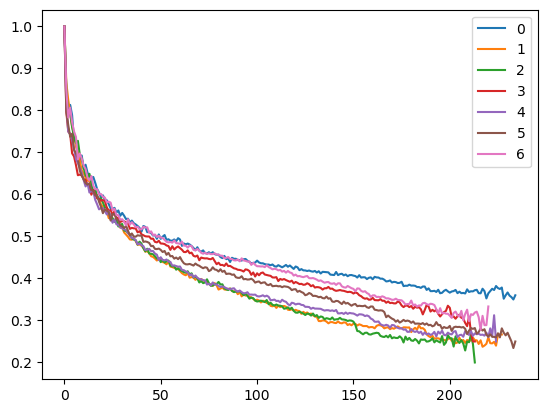

In [9]:
for i in range(7):
    fft_img = np.log(np.abs(np.fft.fftshift(fft2(images[i]))))
    az = azimuthal_averaging(fft_img)
    plt.plot(az)
plt.legend([i for i in range(7)])

In [164]:
centered_result = []
for i in range(7):
    img = pipeline(images[i], i, center = True)
    centered_result.append(img)

centered_res = [] 

for img in centered_result: 
    h, w = img.shape 
    val = 0
    for i in range(h):
        for j in range(w):
            val += img[i][j] * np.exp(-np.sqrt((i - h // 2) ** 2 +  (j - w // 2) ** 2))
            
    centered_res.append(val)

(166, 166)


/var/folders/x1/tylp6nfj5xnb74kpdk36gzzw0000gn/T/ipykernel_41317/4147936517.py:11: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(highpass_img)), cmap='gray')


(187, 130)
(151, 151)
(153, 149)
(159, 159)
(166, 166)
(158, 154)


<Figure size 640x480 with 0 Axes>

In [167]:
res

[8.006833820733114,
 2.046315945387563,
 9.691831836819809,
 19.453395251597062,
 21.200994740227998,
 4.143174289671995,
 25.76897682311935]

In [168]:
centered_res

[5.502374353254851,
 1.589088533510345,
 2.1940765105225637,
 6.345025710244663,
 6.0616962690927325,
 2.2441757837065146,
 15.373336955214201]

In [248]:
def azimuthal_average(img):
    h, w = img.shape
    frequency = [0 for _ in range(int(np.hypot(h // 2, w // 2)) + 1)]
    distance_count = [0 for _ in range(int(np.hypot(h // 2, w // 2)) + 1)]
    for i in range(h):
        for j in range(w):
            distance = int(np.hypot(i - h // 2, j - w // 2))
            distance_count[distance] += 1
            frequency[distance] += np.log(img[i][j])
    frequency = np.array(frequency)
    distance_count = np.array(distance_count) 
    print(frequency, max(frequency))
    frequency = frequency / distance_count
    
    return frequency
    
            
            

In [249]:
fft_img = np.abs(np.log(np.fft.fftshift(fft2(images[0]))))

[   2.77125815   20.71522302   40.47147117   50.99091956   60.41754029
   97.89015884   88.51726477  114.94045706  133.71470202  134.67769201
  160.48821136  151.56918044  187.00116612  214.53362878  204.20434621
  223.51354736  220.93513871  265.90045852  274.02286535  271.28333883
  280.52418176  323.99479789  305.39531044  311.22848309  337.10907349
  371.46005692  389.25976365  361.53376051  369.7771611   419.08186983
  412.81688633  454.31061     434.46995074  452.01668339  492.3189154
  450.78545117  499.70345836  489.07557893  548.25898738  530.32451665
  501.27716798  581.97125289  563.50999602  611.39224506  583.35834512
  572.89981532  621.97067681  615.74821819  652.0922533   642.17012657
  699.42057695  680.1785383   656.24713859  716.93085463  675.39582196
  781.99758132  716.15172872  750.60449752  756.93070618  768.44261851
  819.35915637  799.61690747  812.20511188  826.44377062  801.98830027
  891.72672181  824.26732633  869.38948441  921.30492773  853.51419923
  913.3

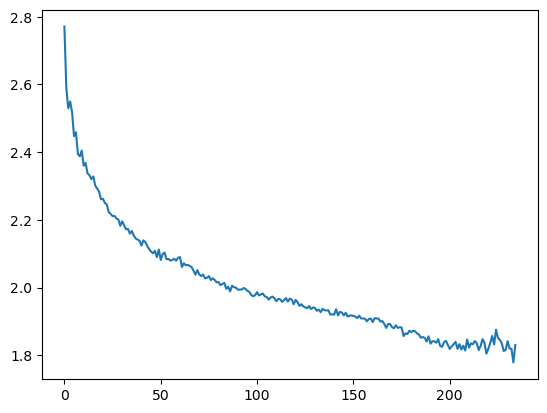

In [250]:
az2 = azimuthal_average(fft_img)
plt.plot(az2)

In [6]:
from tqdm import tqdm


In [7]:
azs = [] 

for i in tqdm(range(7)):
    fft_img = np.log(np.abs(np.fft.fftshift(fft2(images[i]))))
    az = azimuthal_averaging(fft_img)
    azs.append(az)
    
    
    

100%|██████████| 7/7 [00:04<00:00,  1.66it/s]
